In [19]:
import rdkit

                                          SMILES     Lab    RT
0  CCCCCn1nc(C(=O)NC(C(=O)OCC)C(C)(C)C)c2ccccc21  Aarhus  8.53
1            COc1ccc2[nH]cc(CCN(C(C)C)C(C)C)c2c1  Aarhus  4.45
2  C=CCCCn1nc(C(=O)NC(C(=O)OC)C(C)(C)C)c2ccccc21  Aarhus  7.97
3       CC=CC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1  Aarhus  5.29
4                            CC1COC(c2ccccc2)CN1  Aarhus  2.68
                RT
count  3776.000000
mean      7.557123
std       3.854082
min       0.460000
25%       4.830000
50%       6.610000
75%       9.762500
max      23.210000


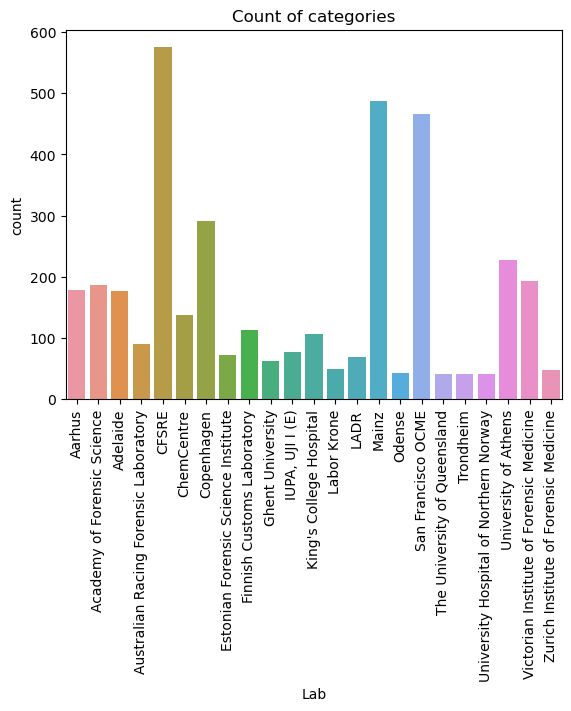

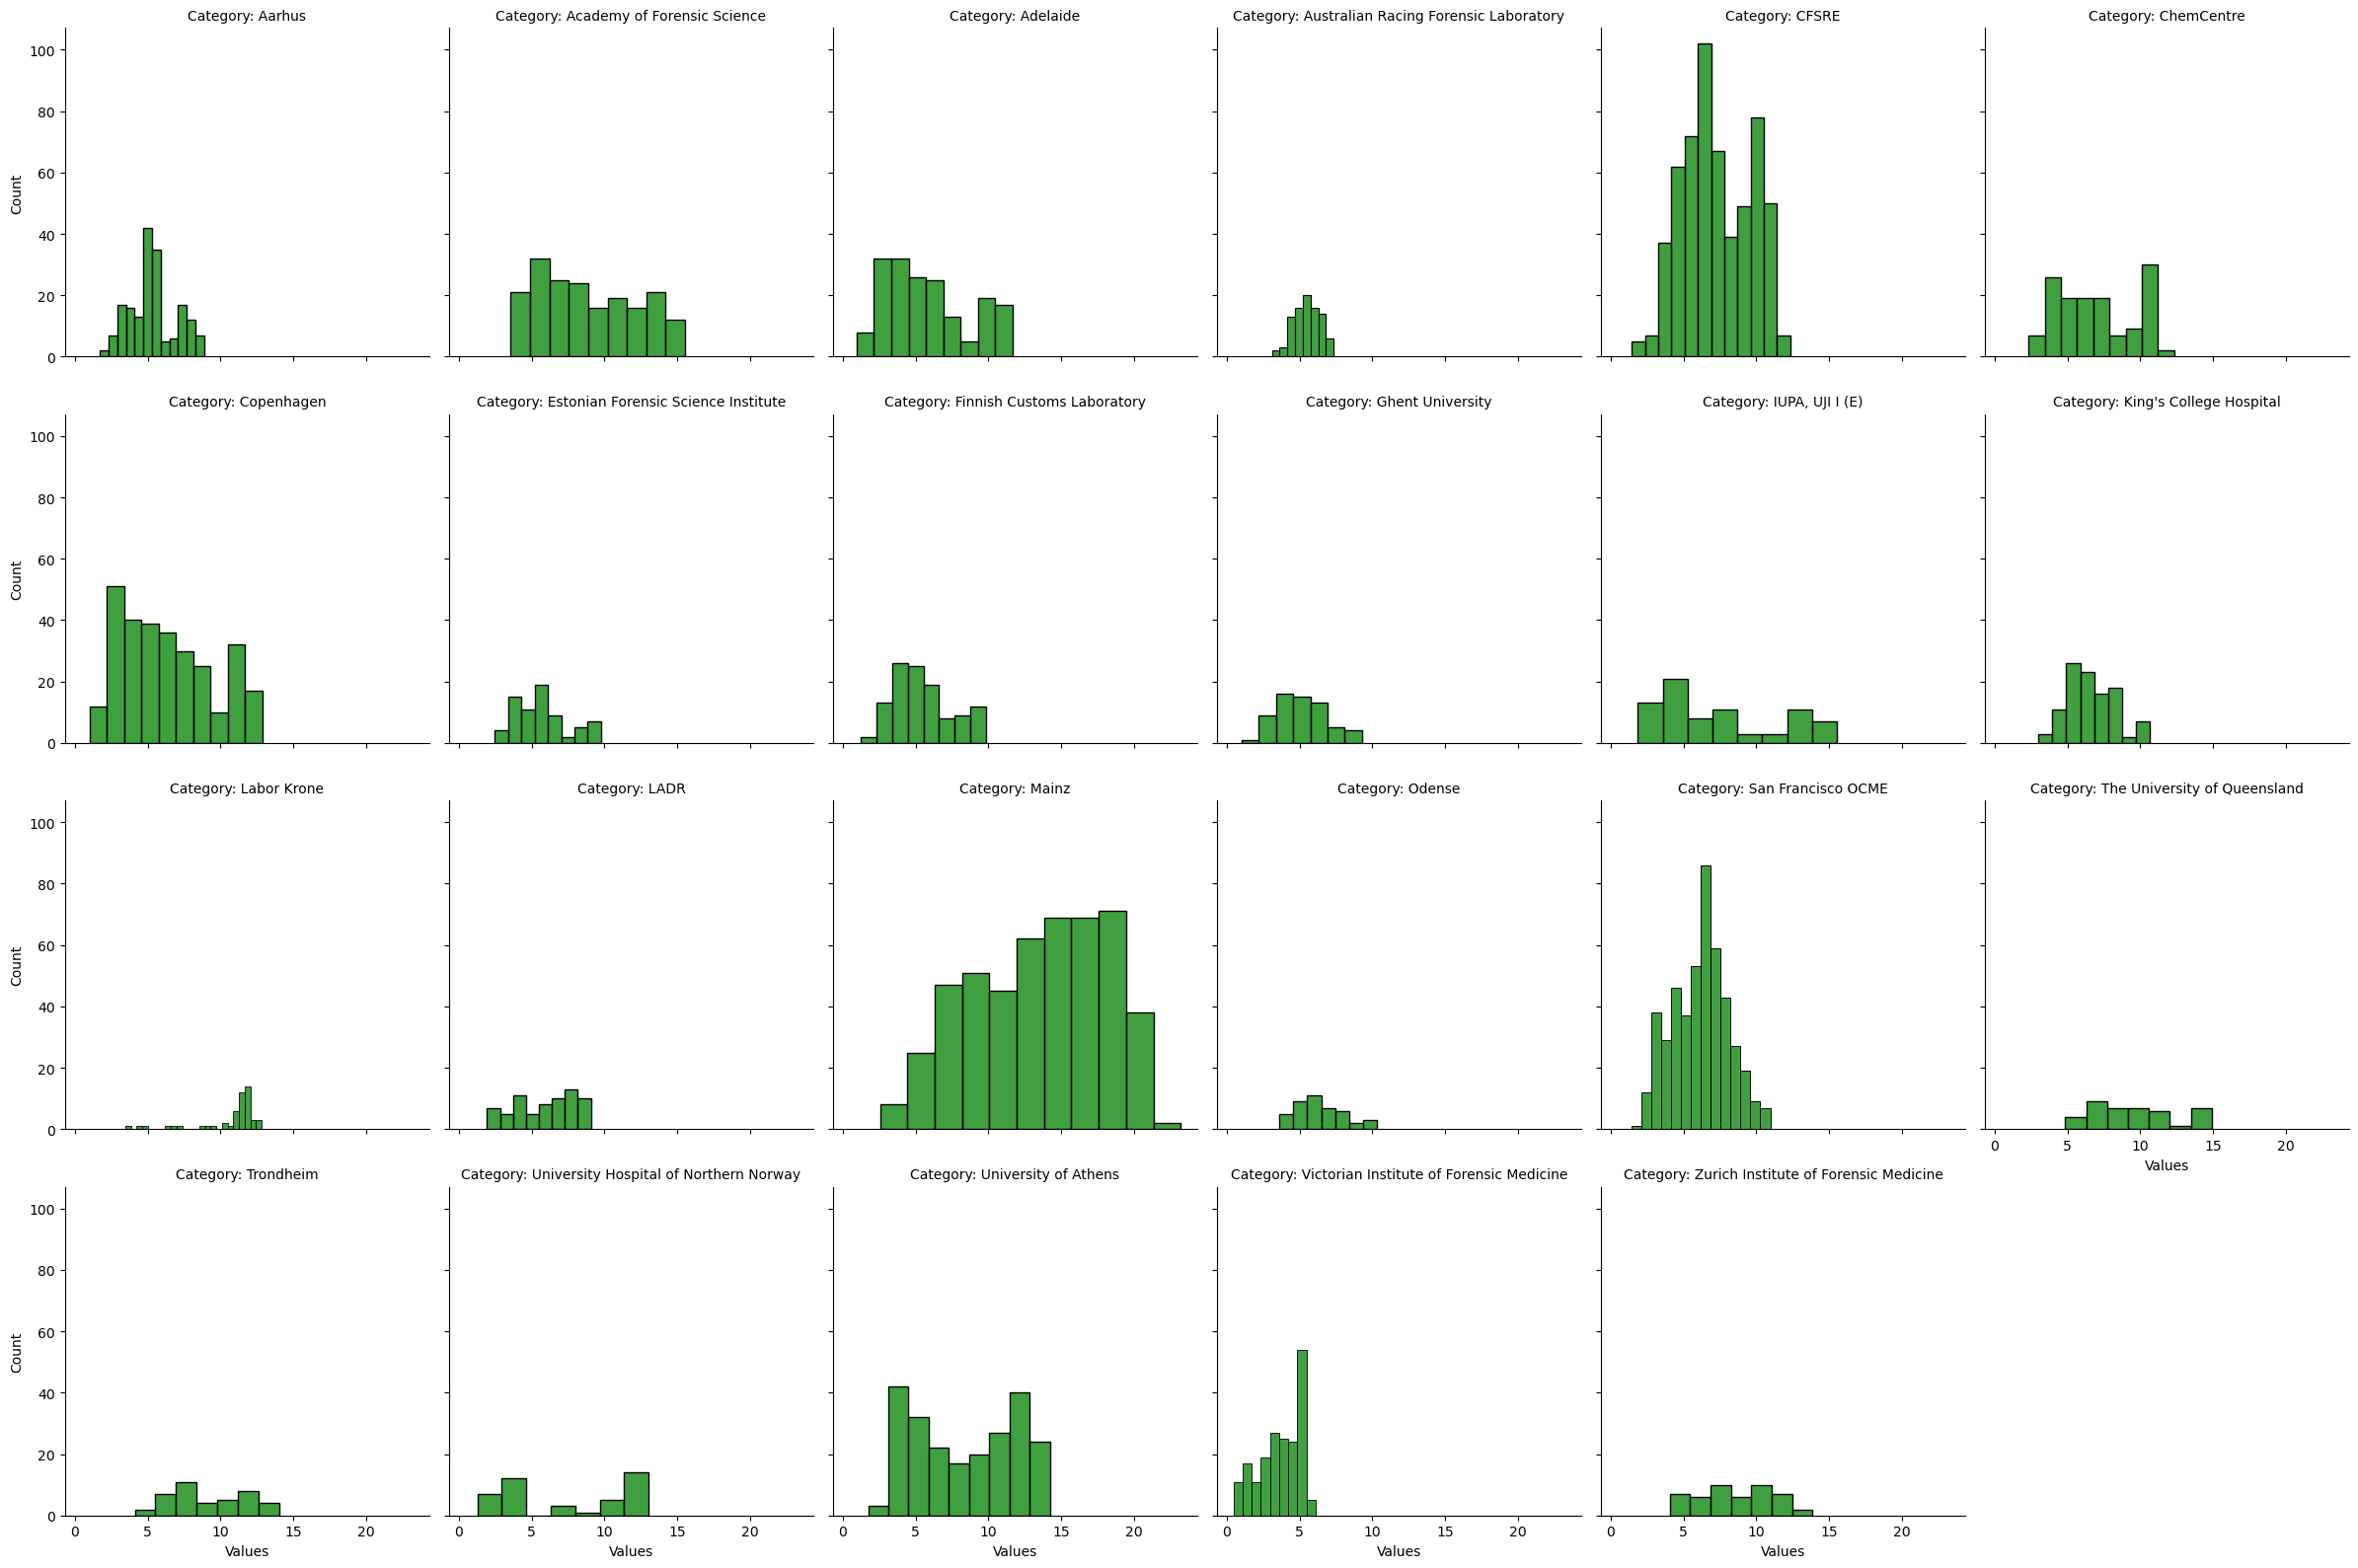

In [20]:
import pandas as pd

df = pd.read_csv('train.csv')

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Print the first 5 rows of the dataframe
print(df.head())

# Print the summary statistics of the dataframe
print(df.describe())

# Plot the count of each category
sns.countplot(data=df, x='Lab')
plt.title('Count of categories')
plt.xticks(rotation=90) # Rotate the x-axis labels for better readability
plt.show()

# Plot the distribution of the values column by categories in separate subplots
g = sns.FacetGrid(data=df, col='Lab', col_wrap=6, height=4,)
g.map(sns.histplot, 'RT', color='green')
g.set_axis_labels('Values', 'Count')
g.set_titles('Category: {col_name}')
#plt.suptitle('Distribution of values by categories')
plt.tight_layout()
plt.show()


In [69]:
# Import modules
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
import networkx as nx
import matplotlib.pyplot as plt

# Define a function to calculate Tanimoto similarity between two fingerprints
def tanimoto_sim(fp1, fp2):
  return DataStructs.FingerprintSimilarity(fp1, fp2)

# Create an empty dictionary to store sub-dataframes for each category
sub_dfs = {}

# Loop over the unique categories in the dataframe
for cat in df['Lab'].unique():
  # Create a sub-dataframe for each category
  sub_df = df[df['Lab'] == cat]
  # Store the sub-dataframe in the dictionary with category name as key and sub-dataframe as value
  sub_dfs[cat] = sub_df

# Create an empty dictionary to store fingerprints for each smiles string
fps = {}

# Loop over the keys and values in the sub-dataframes dictionary
for cat, sub_df in sub_dfs.items():
  # Loop over the smiles strings in the sub-dataframe
  for smi in sub_df['SMILES']:
    # Convert smiles string to molecule object using rdkit.Chem.MolFromSmiles function
    mol = Chem.MolFromSmiles(smi)
    # Generate fingerprint for molecule object using rdkit.Chem.Fingerprints.FingerprintMols function
    fp = FingerprintMols.FingerprintMol(mol)
    # Store the fingerprint in the dictionary with smiles string as key and fingerprint as value
    fps[smi] = fp

# Create an empty dictionary to store averaged similarities for each pair of categories
sim_dict = {}

# Loop over the pairs of categories using itertools.combinations function
for cat1, cat2 in itertools.combinations(sub_dfs.keys(), 2):
  # Create an empty list to store pairwise similarities between fingerprints from each category
  sims = []
  # Loop over the smiles strings in the first category
  for smi1 in sub_dfs[cat1]['SMILES']:
    # Loop over the smiles strings in the second category
    for smi2 in sub_dfs[cat2]['SMILES']:
      # Get the fingerprints from the fps dictionary using smiles strings as keys
      fp1 = fps[smi1]
      fp2 = fps[smi2]
      # Calculate similarity between two fingerprints using tanimoto_sim function
      sim = tanimoto_sim(fp1, fp2)
      # Append similarity to the list
      sims.append(sim)
  # Calculate the mean of the pairwise similarities using numpy.mean function
  mean_sim = np.mean(sims)
  # Store the mean similarity for each pair of categories in the dictionary with tuple of category names as key and mean similarity as value
  sim_dict[(cat1, cat2)] = mean_sim
'''
# Create a network graph using networkx.Graph function
G = nx.Graph()
# Add nodes from the unique categories using networkx.add_nodes_from function
G.add_nodes_from(sub_dfs.keys())
# Add edges from the sim_dict using networkx.add_weighted_edges_from function
G.add_weighted_edges_from([(u, v, w) for (u, v), w in sim_dict.items()])
# Draw the network graph using matplotlib.pyplot and networkx.draw_circular functions
plt.figure(figsize=(10,10))
nx.draw_circular(G, with_labels=True, node_size=1000, font_size=15)
plt.show()
'''

'\n# Create a network graph using networkx.Graph function\nG = nx.Graph()\n# Add nodes from the unique categories using networkx.add_nodes_from function\nG.add_nodes_from(sub_dfs.keys())\n# Add edges from the sim_dict using networkx.add_weighted_edges_from function\nG.add_weighted_edges_from([(u, v, w) for (u, v), w in sim_dict.items()])\n# Draw the network graph using matplotlib.pyplot and networkx.draw_circular functions\nplt.figure(figsize=(10,10))\nnx.draw_circular(G, with_labels=True, node_size=1000, font_size=15)\nplt.show()\n'

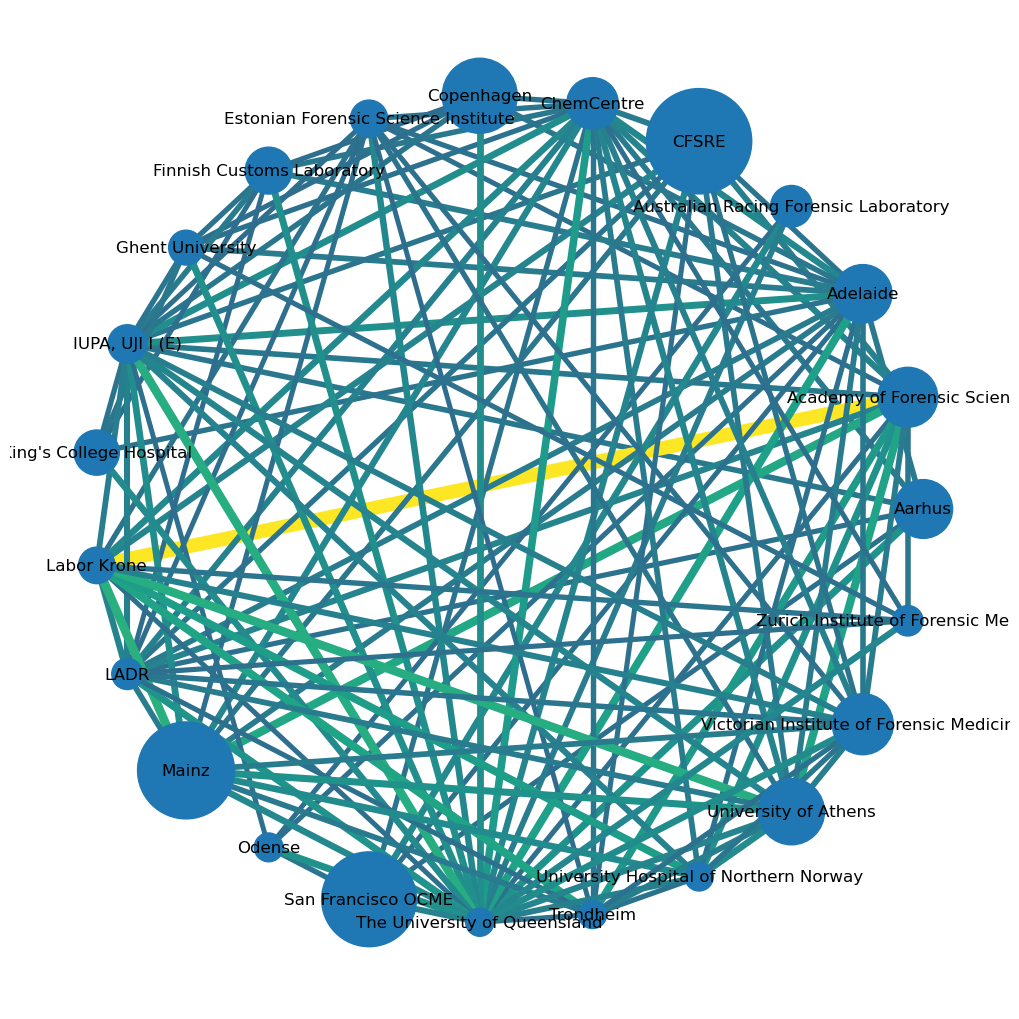

In [70]:
counts = df.groupby('Lab').size()

node_sizes = {cat: count * 10 for cat, count in counts.items()}

G.add_nodes_from(node_sizes.keys())
G.add_nodes_from(node_sizes.keys())

G.add_weighted_edges_from([(u, v, w) for (u, v), w in sim_dict.items()])

plt.figure(figsize=(10,10))
#nx.draw_circular(G, with_labels=True, node_size=1000, font_size=15, edge_color='grey', width=3)
# Create an edge label dictionary from the edge attributes using networkx.get_edge_attributes function
edge_sims = nx.get_edge_attributes(G, 'weight')
#nx.get_edge_attributes(G, 'weight').values()

# Set the edge widths and colors based on the edge similarities
edge_widths = [edge_sims[edge] *10 for edge in G.edges()]
lst = edge_widths 
arr = np.array(lst)

# Calculate the minimum and maximum values of the array
min_val = np.min(arr)
max_val = np.max(arr)

# Subtract the minimum value from the array and divide by the difference between the maximum and minimum values
norm_arr = np.divide(np.subtract(arr, min_val), max_val - min_val)

# Multiply the result by 100
norm_arr = np.multiply(norm_arr, 10)
arr = np.array(norm_arr)

# Calculate the 25th percentile of the array
p25 = np.percentile(arr, q=50)

# Create a boolean mask that indicates which elements of the array are less than or equal to the 25th percentile
mask = np.less_equal(arr, p25)

# Assign zero to the elements of the array that satisfy the mask
arr = np.where(mask, 0, arr)

# Convert the result back to a list
edge_widths = list(arr)
edge_colors = [edge_sims[edge] for edge in G.edges()]

# Draw the circular graph with edge widths and colors
#nx.draw_circular(G, with_labels=True, node_color='lightgreen', edge_color=edge_colors, width=edge_widths)

nx.draw_circular(G, with_labels=True, node_size=list(node_sizes.values()),edge_color=edge_colors, width=edge_widths)

# Draw the edge labels on the graph using networkx.draw_networkx_edge_labels function with alpha parameter to control transparency based on similarity values
#nx.draw_networkx_edge_labels(G, pos=nx.circular_layout(G), edge_labels=edge_labels, alpha = 1)
plt.show()

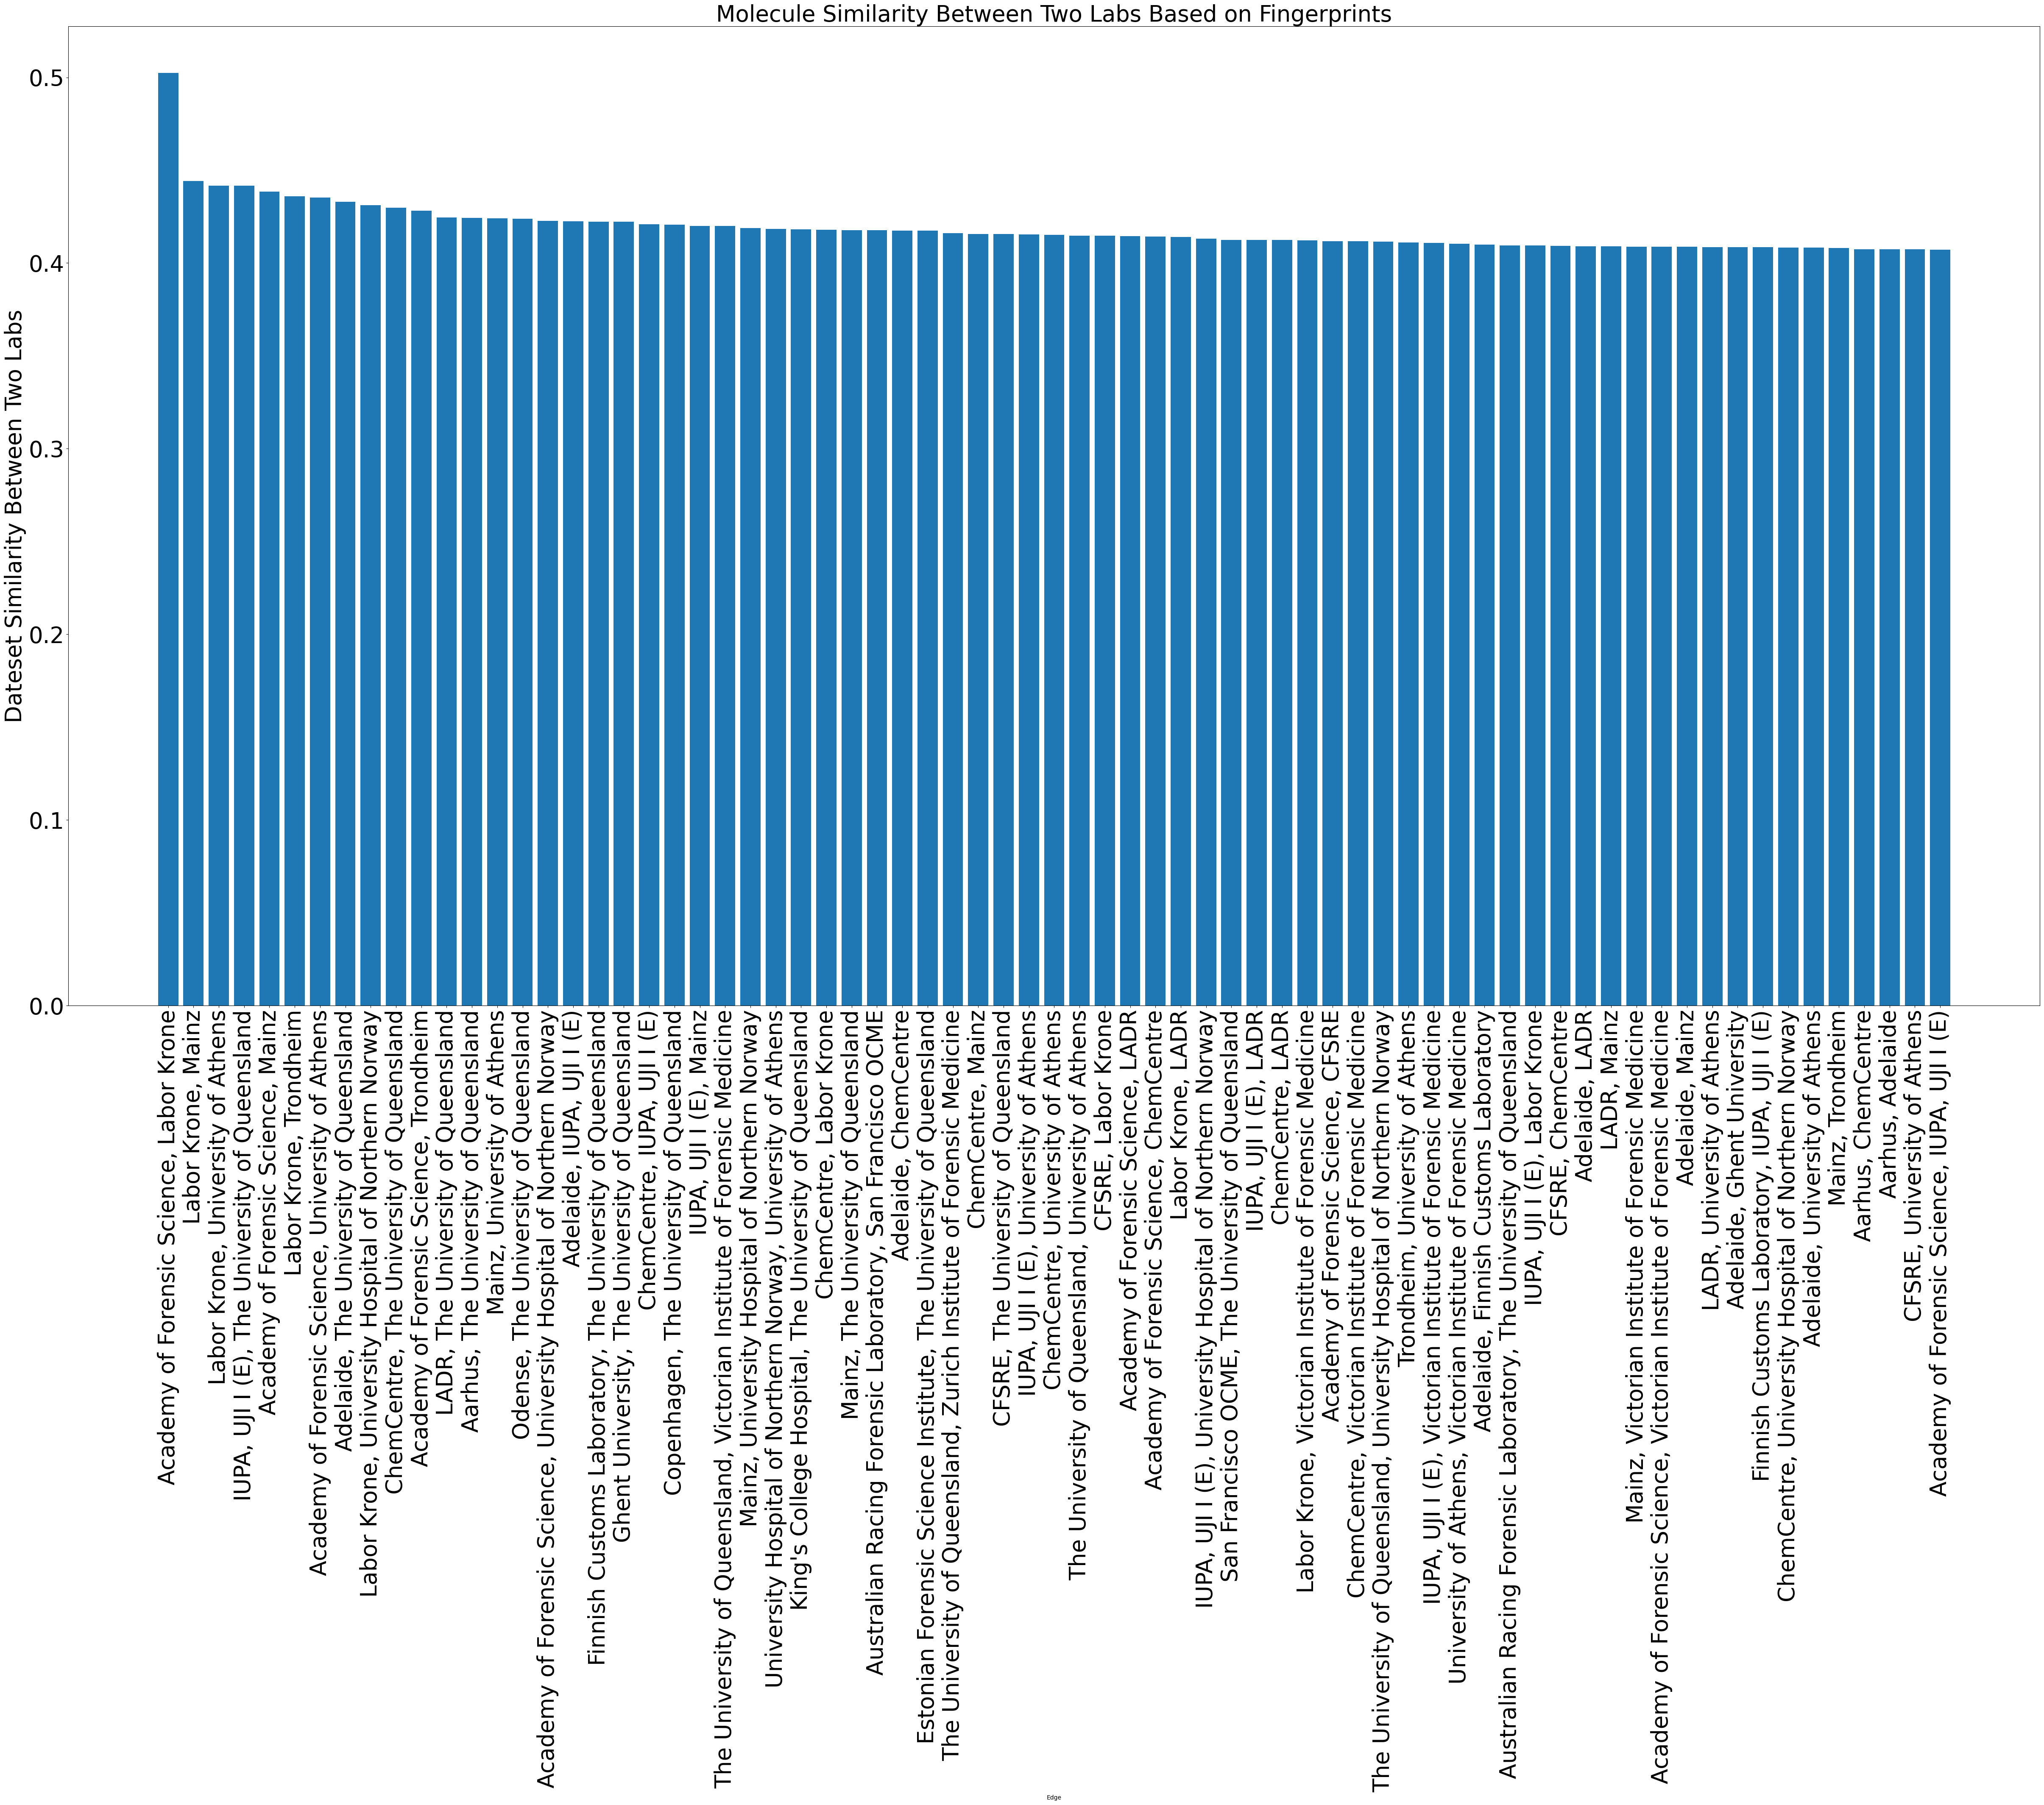

In [118]:

df = pd.DataFrame(edges, columns=['edge', 'weight'])

# Convert the weight column to numeric type
df['weight'] = pd.to_numeric(df['weight'])

# Sort the dataframe by the weight column in ascending order
df = df.sort_values(by='weight',ascending=False)

df =  df.loc[:30,:]
plt.figure(figsize=(60, 30), dpi=100)
# Plot a bar chart with edge as x-axis and weight as y-axis
plt.bar(df['edge'], df['weight'])
plt.xlabel('Edge')
plt.ylabel('Dateset Similarity Between Two Labs', fontsize=38)
plt.title('Molecule Similarity Between Two Labs Based on Fingerprints', fontsize=38)

# Set the x-axis labels to be the edge names
plt.xticks(df['edge'], rotation='vertical',fontsize=38)
plt.yticks(fontsize=38)
# Show or save the plot
plt.show()